> Forecasting with Reddits

**Table of contents**<a id='toc0_'></a>    
1. [Setup](#toc1_)    
2. [Model](#toc2_)    
3. [Functions](#toc3_)    
3.1. [Prepare Data](#toc3_1_)    
3.2. [Train & Evaluate](#toc3_2_)    
3.3. [Sentiment Scores](#toc3_3_)    
3.4. [Load Data](#toc3_4_)    
3.5. [Predict](#toc3_5_)    
4. [Hyperparameter tuning](#toc4_)    
5. [Forecast](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pprint import pprint
from prettytable import PrettyTable
import yfinance as yf
import datetime as dt
from itertools import combinations
import pickle
from itertools import product

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pprint import pprint
import yfinance as yf
import datetime as dt
import datetime
import shap

import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import praw
import prawcore.exceptions

import datetime
import datetime as dt
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

import os

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sohmt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sohmt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sohmt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. <a id='toc2_'></a>[Model](#toc0_)

In [2]:
class DynamicLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_layers, output_size):
        super(DynamicLSTM, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.LSTM(input_size, hidden_sizes[0], num_layers=1, batch_first=True))
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], num_layers=1, batch_first=True))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x, _ = layer(x.to(device))  # Move input to GPU
        x = self.output_layer(x[:, -1, :])  # Take the output from the last time step
        return x

# 3. <a id='toc3_'></a>[Functions](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Prepare Data](#toc0_)

In [3]:

def prepare_data_multivariate(df, choosen_stock, startdate, enddate, features, look_back, predict_type='year'):
    # Choose specific stock
    data = df[df["Stock"] == choosen_stock]

    # Test split
    if predict_type=='year':
        test_data = data[data["Date"].dt.year == 2023]
    elif predict_type=='month':
        test_data = data[(data["Date"].dt.year == 2023) & (data["Date"].dt.month.isin([1]))]
    elif predict_type=='days':
        test_data = data[data["Date"].dt.year == 2023][0:20] 
    elif predict_type=='forecast':
        test_data = data[(data["Date"] >= dt.datetime(2023, 10, 12)) & (data["Date"] <= enddate)]

    # Train split
    if predict_type=='forecast':
        train_data = data[(data["Date"] >= startdate) & (data["Date"] <= dt.datetime(2023, 10, 11))]
    else:
        train_data = data[(data["Date"] >= startdate) & (data["Date"] <= dt.datetime(2022, 12, 31))]
    
    # Feature selection and engineering
    train_data = train_data[features + ["Date"]].values
    test_data = test_data[features + ["Date"]].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data[:, :-1] = scaler.fit_transform(train_data[:, :-1])
    test_data[:, :-1] = scaler.transform(test_data[:, :-1])
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back):
        X, Y, dates = [], [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), :-1])
            Y.append(dataset[i + look_back, 0])
            dates.append(dataset[i + look_back, -1])  # Assuming the last column is 'Date'
        return np.array(X), np.array(Y), np.array(dates)
    train_X, train_Y, train_dates = create_sequences(train_data, look_back)
    test_X, test_Y, test_dates = create_sequences(test_data, look_back)
    
    # Convert data to PyTorch tensors and move to GPU
    train_X = torch.Tensor(train_X.astype(np.float32)).to(device)
    train_Y = torch.Tensor(train_Y).to(device)
    test_X = torch.Tensor(test_X.astype(np.float32)).to(device)
    test_Y = torch.Tensor(test_Y).to(device)
    
    return train_X, train_Y, train_dates, test_X, test_Y, test_dates, scaler, test_data

## 3.2. <a id='toc3_2_'></a>[Train & Evaluate](#toc0_)

In [4]:
def train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, test_data, test_dates, visualize=True):
    # Initialize the model
    # model = MultivariateLSTMModel(input_size, hidden_sizes, num_layers, output_size)
    # model = DynamicLSTM(input_size, hidden_sizes, num_layers, output_size)
    model = DynamicLSTM(input_size, hidden_sizes, num_layers, output_size).to(device)
    # print(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Move data to GPU
    train_X, train_Y, test_X, test_Y = train_X.to(device), train_Y.to(device), test_X.to(device), test_Y.to(device)
    print(train_X.shape)

    # Training the model
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs.view(-1), train_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Calculate predictions
    model.eval()
    train_predict = model(train_X).view(-1).cpu().detach().numpy()
    test_predict = model(test_X).view(-1).cpu().detach().numpy()
    
    # Compute RMSE & MAPE
    train_rmse = mean_squared_error(train_Y.cpu(), train_predict, squared=False)
    test_rmse = mean_squared_error(test_Y.cpu(), test_predict, squared=False)
    train_mape = mean_absolute_percentage_error(train_Y.cpu(), train_predict)
    test_mape = mean_absolute_percentage_error(test_Y.cpu(), test_predict)
    
    # Inverse Scaling
    # --> 1.test_predict
    test_data1 = test_data[:, 1:-1]
    # Ensure the second array has the same number of rows as the first array
    test_data1 = test_data1[:test_predict.reshape(-1, 1).shape[0], :]
    # Append the arrays
    test_data1 = np.hstack((test_predict.reshape(-1, 1), test_data1)) 
    test_predict_inverse = scaler.inverse_transform(test_data1)[:,0]
    
    # --> 2.test_Y
    test_data2 = test_data[:, :-1]
    test_data2 = test_data2[:test_predict.reshape(-1, 1).shape[0], :]
    test_Y_inverse = scaler.inverse_transform(test_data2)[:,0]
    
    # Visualize test and predictions
    if visualize == True:
        plt.figure(figsize=(10, 5))
        plt.plot(test_dates, test_Y_inverse, label='True', linewidth=2)
        plt.plot(test_dates, test_predict_inverse, label='Predicted', linewidth=2)
        plt.title("Test vs. Predicted Prices")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    
    return model, loss, train_rmse, test_rmse, train_mape, test_mape, test_Y_inverse, test_predict_inverse 

## 3.3. <a id='toc3_3_'></a>[Sentiment Scores](#toc0_)

In [5]:
# Script to scrape Reddit posts related to all stocks from different subreddits

# Initialize the Reddit API client
reddit = praw.Reddit(
    client_id="2aV6_rxA1c44CoHtxY6e0A",
    client_secret="7rbu00bmyQOlnHCu-xjyTa-U5har-g",
    user_agent="Project Capstone"
)

# list of subreddits to search
subreddits_to_search = ['stocks', 'investing', 'wallstreetbets', 'finance', 'economy', 'stockmarket', 'business']

# list of search queries
search_queries = ['GameStop or GME' ] # 'Google Stocks OR GOOG', 'Microsoft Stocks OR MSFT', 'Amazon Stocks or AMZN', 'Netflix Stocks OR NFLX', 'TESLA Stocks OR TSLA','Nvidia stocks or NVDA', 

# Define the date range (January 1, 2015, to December 31, 2020) for consistency
start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2023, 12, 4)

# lists to store data
titles = []
authors = []
scores = []
urls = []
contents = []
post_dates = []
subreddit_names = []
query_names = []

# Iterate through each subreddit
for subreddit_name in subreddits_to_search:
    for search_query in search_queries:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            posts = subreddit.search(search_query, limit=None)

            # Iterate through the search results and collect data
            for post in posts:
                post_date = pd.to_datetime(post.created_utc, unit='s').date()
                if start_date <= post_date <= end_date:
                    if post.selftext:  # Check if the post has text content
                        titles.append(post.title)
                        authors.append(post.author)
                        scores.append(post.score)
                        urls.append(post.url)
                        contents.append(post.selftext)
                        post_dates.append(pd.to_datetime(post.created_utc, unit='s'))
                        subreddit_names.append(subreddit_name)
                        query_names.append(search_query[-4:])

        # handle the exceptions
        except prawcore.exceptions.NotFound as e:
            print(f"Error in subreddit '{subreddit_name}': {e}")
        except prawcore.exceptions.Forbidden as e:
            print(f"Access forbidden in subreddit '{subreddit_name}': {e}")
        except praw.exceptions.APIException as e:
            print(f"API Error: {e}")
            # Wait for a while before retrying (e.g., 5 seconds)
            time.sleep(5)

# Create a DataFrame from the collected data
data = {
    'Stock': query_names,
    'Subreddit': subreddit_names,
    'Title': titles,
    'Author': authors,
    'Score': scores,
    'URL': urls,
    'Content': contents,
    'Date': post_dates,
}
df = pd.DataFrame(data)

# drop duplicate
df = df.drop_duplicates(subset='URL')

# Sort by date
df = df.sort_values(by='Date')

df_reddit = df

# drop the specific column
# df_reddit.drop(columns='Unnamed: 0', inplace=True)

# Combine columns
df_reddit['Text'] = df_reddit['Title'] + ' ' + df_reddit['Content']

# Select specific columns to consider
selected_columns = ['Date','Text','Stock']
df_reddit = df_reddit[selected_columns]

# Convert to suitable datatype
df_reddit.loc[:, 'Date'] = pd.to_datetime(df_reddit['Date']).dt.date

# Define a function to clean and preprocess text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin the tokens to form cleaned text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the clean_text function to 'Title' and 'Content' columns using lambda
df_reddit.loc[:, 'Cleaned_Text'] = df_reddit['Text'].apply(lambda x: clean_text(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
def perform_sentiment_analysis(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis for each 'text' in the DataFrame
    sentiment_scores = df['Text'].apply(lambda x: sia.polarity_scores(x))

    # Map the sentiment scores to sentiment labels
    sentiment_labels = sentiment_scores.apply(lambda x: x['compound'] if x['compound'] > 0 else x['compound'] if x['compound'] < 0 else x['compound'])

    # Add sentiment labels to the DataFrame
    df['VADER_sentiment'] = sentiment_labels

    return df

df_reddit = perform_sentiment_analysis(df_reddit)


df_reddit.to_csv('RedditPosts.csv')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 3.4. <a id='toc3_4_'></a>[Load Data](#toc0_)

In [9]:
def load_data(choosen_stock, predict_type):    
    yf.pdr_override() # Override pandas datareader with yfinance
    y_symbols = [choosen_stock]

    # Train split
    if predict_type=='forecast':
        # State the dates
        startdate = dt.datetime(2018, 1, 1) # start date
        enddate = dt.datetime(2023, 12, 4) # end date

        # Retrieve historical stock price data for the specified symbols and date range
        df = yf.download(y_symbols, start=startdate, end=enddate) 
        df = df.reset_index() # Reset the index to make 'Date' a regular column
        df['Stock'] = choosen_stock # add 'Stock' column
        df = df[['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] # Reorder the columns
        df['Date'] = pd.to_datetime(df['Date'])
        
        # add new row
        new_row = [{'Date':pd.to_datetime('2023-12-4T00:00:00.000000000'), 'Stock': choosen_stock , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        new_row = [{'Date':pd.to_datetime('2023-12-5T00:00:00.000000000'), 'Stock': choosen_stock , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        new_row = [{'Date':pd.to_datetime('2023-12-6T00:00:00.000000000'), 'Stock': choosen_stock , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        new_row = [{'Date':pd.to_datetime('2023-12-7T00:00:00.000000000'), 'Stock': choosen_stock , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        new_row = [{'Date':pd.to_datetime('2023-12-8T00:00:00.000000000'), 'Stock': choosen_stock , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}]
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        
        return df, startdate, dt.datetime(2023, 12, 8) 
    
    else:
        startdate = dt.datetime(2018, 1, 1) # start date
        enddate = dt.datetime(2023, 11, 4) # end date
        
        # Retrieve historical stock price data for the specified symbols and date range
        df = yf.download(y_symbols, start=startdate, end=enddate) 
        df = df.reset_index() # Reset the index to make 'Date' a regular column
        df['Stock'] = choosen_stock # add 'Stock' column
        df = df[['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] # Reorder the columns
        df['Date'] = pd.to_datetime(df['Date'])
  
        return df, startdate, enddate

## 3.5. <a id='toc3_5_'></a>[Predict](#toc0_)

In [74]:
# Standalone prediction
def predict(choosen_stock):
    # Load the data
    data, startdate, enddate = load_data(choosen_stock)

    # Append the last row to the DataFrame
    new_row = [{'Date':pd.to_datetime('2023-12-01T00:00:00.000000000'), 'Stock': choosen_stock , 'Adj Close': 0.0, 'Close': 0.0 , 'High': 0.0,'Low': 0.0, 'Open':0.0, 'Volume':0.0}]
    data = pd.concat([data, pd.DataFrame(new_row)], ignore_index=True)

    # 1. Hyperparameters
    look_back = 5 # No. of Lags to consider
    predict_type = 'Predict' # Predict type ['Year', 'Month', 'Days','Predict']
    features = ['Close', 'High', 'Low', 'Open', 'Volume']
    predict_type = 'Predict'                            # Predict type ['Year', 'Month', 'Days','Predict']
    hidden_sizes = [64, 64]                   # Adjust the hidden_size values as needed
    num_layers = 2                       # [1, 2, 3]
    learning_rate = 0.001         # [0.005, 0.01, 0.02]  
    num_epochs = 100                                    # [50, 100, 200] 

    # Prepare the data
    train_X, train_Y, train_dates, test_X, test_Y, test_dates, scaler, test_data = prepare_data_multivariate(data, choosen_stock, startdate, enddate, features=features, look_back=look_back, predict_type=predict_type )

    # 2. Hyperparameters
    input_size = 5  # Number of input features (High, Low, Open, Close, Volume)
    output_size = 1  # Number of output features (Close price)
    num_epochs = 100

    # Create the model
    model, loss, train_rmse, test_rmse, train_mape, test_mape, test_Y_inverse, test_predict_inverse  = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, test_data, visualize=False)
    
    # Formatting the prices to a desired decimal form
    formatted_test_Y = ["{:.4f}".format(price) for price in test_Y_inverse.flatten()]
    formatted_test_predict = ["{:.4f}".format(price) for price in test_predict_inverse.flatten()]
    formatted_dates = [test_dates.strftime('%Y-%m-%d') for test_dates in test_dates]

    return formatted_test_Y, formatted_test_predict, formatted_dates

# 4. <a id='toc4_'></a>[Hyperparameter tuning](#toc0_)

In [67]:
# Dictionary to store the best models for each ticker
all_best_models = {}

for ticker in ['GOOG', 'MSFT', 'AMZN', 'NFLX', 'TSLA', 'NVDA']:#, 'GME']:
    print("\n" + ticker)
    
    # Hyperparameters
    choosen_stock = ticker                              # ['GOOG', 'MSFT', 'META', 'AMZN', 'NFLX', 'TSLA', 'NVDA']
    look_back_values = [5]        
    # No. of Lags to consider [3, 5, 10, 20]
    predict_type = 'forecast'                            # Predict type ['year', 'month', 'days','predict']
    hidden_size_options = [64, 128]                      # Adjust the hidden_size values as needed
    num_layers_values = [1,2]                       # [1, 2, 3]
    learning_rate_values = [0.001, 0.01, 0.005]         # [0.005, 0.01, 0.02]  
    num_epochs = 100                                    # [50, 100, 200] 
    top_k = 1                                           # Get the top k performing models

    # ?
    years_to_include = [2015, 2016, 2017, 2018, 2019]
    train_days_values = [-1, 60, 100, 365, 365*2]


    # Features
    features = ['Close', 'High', 'Low', 'Open', 'Volume', 'reddit_compound']
    input_size = 6  # Number of input features (High, Low, Open, Close, Volume)
    output_size = 1  # Number of output features (Close price)


    # Load the data
    df, startdate, enddate = load_data(choosen_stock, predict_type)
    
    # print(df.head)
    # print(df.shape)

    
    
    
    df_reddit = pd.read_csv("RedditPosts.csv")
    df_reddit = df_reddit[df_reddit["Stock"] == choosen_stock]
    df_reddit.rename(columns = {'VADER_sentiment':'reddit_compound'}, inplace = True)
    sentiments_reddit = df_reddit.groupby('Date')['reddit_compound'].mean()
    df_reddit = pd.DataFrame(sentiments_reddit)
    df_reddit = df_reddit.reset_index()
    df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])
    
    
    df = df.merge(df_reddit, left_on = 'Date', right_on='Date',  how='left')
    
    # print(df.head)
    # print(df.shape)

    # df['all_compound'] = np.select(conditions, choices, default=np.nan)
    nan_count = df['reddit_compound'].isnull().sum()
    print("Number of NaN values in 'new_column':", nan_count)
    df['reddit_compound'] = df['reddit_compound'].ffill()
    filtered_df = df[df['Stock']==choosen_stock]
    nan_count = filtered_df['reddit_compound'].isna().sum()
    print("Number of NaN values in 'new_column':", nan_count)
    filtered_df.head()
    
    df = filtered_df
    
    df = df.dropna()
    
    # Store best_models
    best_models = []

    # Hyperparameter tuning loop

    for num_layers in num_layers_values:
        hidden_size_values = list(product(hidden_size_options, repeat=num_layers))
        # print(hidden_size_values)
        for hidden_size in hidden_size_values:
            # print(hidden_size)
            for look_back in look_back_values:
                for learning_rate in learning_rate_values:
                    # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                    # Prepare the data
                    train_X, train_Y, train_dates, test_X, test_Y, test_dates, scaler, test_data = prepare_data_multivariate(df, choosen_stock, startdate, enddate, features=features, look_back=look_back, predict_type=predict_type)
                    model, loss, train_rmse, test_rmse, train_mape, test_mape, test_Y_inverse, test_predict_inverse = train_evaluate_lstm_multivariate(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, test_data, test_dates, visualize=False)
                    best_models.append({
                        "model" : model,
                        "look_back" : look_back,
                        "learning_rate" : learning_rate,
                        "input_size" : input_size,
                        "hidden_size" : hidden_size,
                        "num_layers" : num_layers,
                        "output_size" : output_size,
                        "test_rmse": test_rmse,
                        "test_mape": test_mape,
                        "test_X": test_X,
                        "test_Y_inverse":test_Y_inverse,
                        "test_predict_inverse":test_predict_inverse,
                        "test_dates":test_dates,
                        "test_data" : test_data,
                    })

    # Sort the models by RMSE in ascending order
    best_models.sort(key=lambda x: (x["test_rmse"], x["test_mape"]))

    # Store the top-k performing models for the current ticker
    all_best_models[ticker] = best_models[:top_k]

# Save Parameters & Weights
for ticker, models in all_best_models.items():
    for idx, model_info in enumerate(models, start=1):
        # Save parameters for the model reload
        params_file_name = "Saved Params/" + ticker + "_params.pkl"
        with open(params_file_name, 'wb') as file:
            pickle.dump(model_info, file)
        # print(f"Model Parameters for {ticker} saved to {params_file_name}")
        
        # Save the model weights to a pickle file
        model_filename = f"Saved Models/{ticker}_model"
        torch.save(model_info["model"].state_dict(), model_filename)
        # print(f"Model weights for {ticker} saved to {model_filename}")


# Print the best models for each ticker
# for ticker, models in all_best_models.items():
#     print(f"\nTop {top_k} Performing Model for {ticker}:")
#     pprint(models)

# Assuming all_best_models is a dictionary with tickers as keys and a list of best models as values
table = PrettyTable()
table.field_names = ["Ticker", "Model", "Look Back", "Learning Rate", "Input Size", "Hidden Size", "Num Layers", "Output Size", "Test RMSE", "Test MAPE"]

for ticker, models in all_best_models.items():
    for idx, model_info in enumerate(models, start=1):
        table.add_row([
            ticker,
            idx,
            model_info["look_back"],
            model_info["learning_rate"],
            model_info["input_size"],
            model_info["hidden_size"],
            model_info["num_layers"],
            model_info["output_size"],
            round(model_info["test_rmse"], 4),
            round(model_info["test_mape"], 4),
        ])

# Print the combined table
print("Top Performing Models:")
print(table)


GOOG
[*********************100%%**********************]  1 of 1 completed
Number of NaN values in 'new_column': 1106
Number of NaN values in 'new_column': 26
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])
torch.Size([1423, 5, 6])

MSFT
[*********************100%%**********************]  1 of 1 completed
Number of NaN values in 'new_column': 1112
Number of NaN values in 'new_column': 20
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.Size([1429, 5, 6])
torch.S

# 5. <a id='toc5_'></a>[Forecast](#toc0_)

In [68]:
# Forecast next day

stocks = ['GOOG', 'MSFT', 'AMZN', 'NFLX', 'TSLA', 'NVDA', 'GME']

for choosen_stock in stocks:
    print("\n"+choosen_stock)
    
    # Function Call
    file = open("Saved Params/"+choosen_stock+"_params.pkl",'rb')
    object_file = pickle.load(file)
    model = DynamicLSTM(object_file['input_size'], object_file['hidden_size'], object_file['num_layers'], object_file['output_size']).to(device)
    model.load_state_dict(torch.load("Saved Models/"+choosen_stock+"_model"))
    model.eval()
    
    test_predict = model(object_file['test_X']).view(-1).cpu().detach().numpy()
    test_data = object_file['test_data']
    test_predict_inverse = object_file['test_predict_inverse']
    test_Y_inverse = object_file['test_Y_inverse']
    
    formatted_dates = [test_dates.strftime('%Y-%m-%d') for test_dates in object_file["test_dates"]]
    formatted_test_Y = ["{:.4f}".format(price) for price in test_Y_inverse.flatten()]
    formatted_test_predict = ["{:.4f}".format(price) for price in test_predict_inverse.flatten()]
    
    formatted_dates = formatted_dates[-14:-4]
    formatted_test_predict = formatted_test_predict[-14:-4]
    
    # Display
    # Remove the first value and shift up the remaining values
    actual_prices = formatted_test_Y[0:] + ['']
    actual_prices = actual_prices[-10:]
    table = PrettyTable()
    table.field_names = ["Date", "Actual Price", "Predicted Price"]
    for date, actual_price, predicted_price in zip(formatted_dates, actual_prices, formatted_test_predict):
        # Add a separator line before the last row
        if date == formatted_dates[-1]:
            table.add_row(["-" * 10, "-" * 12, "-" * 16])
        table.add_row([date, round(float(actual_price), 2) if actual_price != '' else 'TBA', round(float(predicted_price), 2)])
    print(table)


GOOG
+------------+--------------+------------------+
|    Date    | Actual Price | Predicted Price  |
+------------+--------------+------------------+
| 2023-11-20 |    137.92    |      136.88      |
| 2023-11-21 |    138.62    |      137.07      |
| 2023-11-22 |    140.02    |      137.79      |
| 2023-11-24 |    138.22    |      138.71      |
| 2023-11-27 |    138.05    |      138.9       |
| 2023-11-28 |    138.62    |      138.69      |
| 2023-11-29 |    136.4     |      138.58      |
| 2023-11-30 |    133.92    |      138.27      |
| 2023-12-01 |    133.32    |      136.56      |
| ---------- | ------------ | ---------------- |
| 2023-12-04 |     TBA      |      135.28      |
+------------+--------------+------------------+

MSFT
+------------+--------------+------------------+
|    Date    | Actual Price | Predicted Price  |
+------------+--------------+------------------+
| 2023-11-20 |    377.44    |      360.47      |
| 2023-11-21 |    373.07    |      360.98      |
| 2023-1

# Plots needed

In [14]:
df_reddit = pd.read_csv("RedditPosts.csv")
df_reddit.head()

,Unnamed: 0,Date,Text,Stock,Cleaned_Text,VADER_sentiment
0,192,2018-01-05,GME The bulls say it’s a value play. The bear...,GME,gme bull say ’ value play bear say blockbuster...,0.9231
1,50,2018-01-26,Quick Story on how I got into and started inve...,GME,quick story got started investing bored work f...,0.9855
2,179,2018-03-19,I bought a whole bunch of $GME today. This is ...,GME,bought whole bunch gme today opportunity tell ...,0.5200
3,508,2018-09-06,(9/6) - Thursday Stock Market News & Movers #G...,GME,96 thursday stock market news mover good morni...,0.9933
4,89,2018-09-06,(9/6) - Thursday Stock Market News & Movers #G...,GME,96 thursday stock market news mover good morni...,0.9941


In [24]:
choosen_stock = "GME"
predict_type = "predict"

# Load the data
df, startdate, enddate = load_data(choosen_stock, predict_type)
print(df.shape)

df_reddit = pd.read_csv("RedditPosts.csv")

df_reddit.rename(columns = {'VADER_sentiment':'reddit_compound'}, inplace = True)
sentiments_reddit = df_reddit.groupby('Date')['reddit_compound'].mean()
df_reddit = pd.DataFrame(sentiments_reddit)
df_reddit = df_reddit.reset_index()
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])
print(df_reddit.shape)
print(df_reddit.head())


    
df = df.merge(df_reddit, left_on = 'Date', right_on='Date',  how='left')
print(df.head())
print(df.shape)

nan_count = df['reddit_compound'].isnull().sum()
print("Number of NaN values in 'new_column':", nan_count)
df['reddit_compound'] = df['reddit_compound'].ffill()
# filtered_df = df[df['Stock']==choosen_stock]
# nan_count = filtered_df['reddit_compound'].isna().sum()
# print("Number of NaN values in 'new_column':", nan_count)
# filtered_df.head()

[*********************100%%**********************]  1 of 1 completed


(1471, 8)
(256, 2)
        Date  reddit_compound
0 2018-01-05          0.92310
1 2018-01-26          0.98550
2 2018-03-19          0.52000
3 2018-09-06          0.99370
4 2018-11-30          0.99585
        Date Stock  Adj Close   Close    High    Low    Open    Volume  \
0 2018-01-02   GME   3.988464  4.5650  4.5725  4.445  4.4900  11330800   
1 2018-01-03   GME   3.975359  4.5500  4.5925  4.480  4.5725  15156800   
2 2018-01-04   GME   4.001570  4.5800  4.5950  4.490  4.5500  11125200   
3 2018-01-05   GME   4.080203  4.6700  4.6825  4.555  4.5950  12076000   
4 2018-01-08   GME   4.200338  4.8075  4.8500  4.700  4.7000  14673600   

   reddit_compound  
0              NaN  
1              NaN  
2              NaN  
3           0.9231  
4              NaN  
(1471, 9)
Number of NaN values in 'new_column': 1277


In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, 482 to 1470
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             989 non-null    datetime64[ns]
 1   Stock            989 non-null    object        
 2   Adj Close        989 non-null    float64       
 3   Close            989 non-null    float64       
 4   High             989 non-null    float64       
 5   Low              989 non-null    float64       
 6   Open             989 non-null    float64       
 7   Volume           989 non-null    int64         
 8   reddit_compound  180 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 77.3+ KB


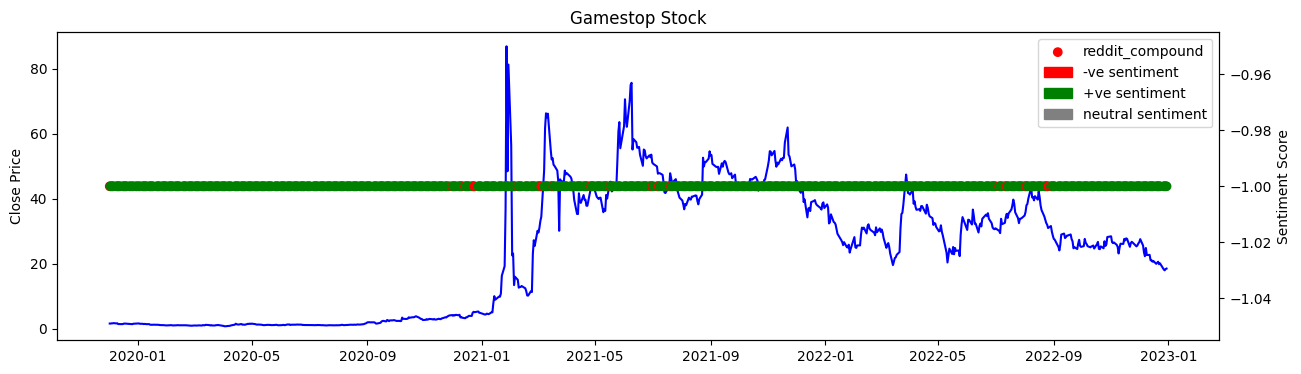

In [64]:
df2 = df[(df['Date']>pd.to_datetime('2019-12-01')) & (df['Date']<pd.to_datetime('2023-01-01')) ]

# Create the plot
fig, ax1 = plt.subplots(figsize=[15,4])

# Plot the close price line
ax1.plot(df2['Date'], df2['Close'], label='Close',color='blue')

# Plot the reddit compound scatter points with color based on value
colors = ['red' if val < 0 else 'green' for val in df2['reddit_compound']]
ax2 = ax1.twinx()
ax2.scatter(df2['Date'], df2['reddit_compound'], c=colors)


# Add labels and title
# ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax2.set_ylabel('Sentiment Score')
plt.title('Gamestop Stock')

# Add legend
# Add legend
handles, labels = ax2.get_legend_handles_labels()
handles.extend([plt.Circle((0, 0), 0.1, color='red'), plt.Circle((0, 0), 0.1, color='green'), plt.Circle((0, 0), 0.1, color='grey')])
labels.extend(['-ve sentiment', '+ve sentiment', 'neutral sentiment'])
plt.legend(handles, labels)


# Show the plot
plt.show()

In [22]:
check = pd.read_csv("RedditPosts.csv")
print(check.iloc[148,:])
check = check[['Date', 'Text', 'Cleaned_Text', 'VADER_sentiment']]
check['Date'] = pd.to_datetime(check['Date'])

Unnamed: 0                                                       377
Date                                                      2021-01-27
Text               Don't Tread on GME. Ride or DIE. YOLO for tend...
Stock                                                            GME
Cleaned_Text       dont tread gme ride die yolo tendies get tendi...
VADER_sentiment                                               0.6552
Name: 148, dtype: object


In [16]:
check = check[(check['Date'] == pd.to_datetime('2021-01-27'))]
check['Text'][148]

"Don't Tread on GME. Ride or DIE. YOLO for tendies! GET THE TENDIES. Out with the old money and in with the new #GME #Gamestop #tendies # yolo Idk wtf is going on but this shit is exciting. Dropped a couple grand in the excitement this afternoon! How do I stonk?"

In [18]:
print("Jan 27, 2021\nDon't Tread on GME. Ride or DIE. YOLO for tendies! GET THE TENDIES. \nOut with the old money and in with the new \n#GME /#Gamestop #tendies # yolo Idk wtf is going on but this shit is exciting. \nDropped a couple grand in the excitement this afternoon! How do I stonk?")

Jan 27, 2021
Don't Tread on GME. Ride or DIE. YOLO for tendies! GET THE TENDIES. 
Out with the old money and in with the new 
#GME /#Gamestop #tendies # yolo Idk wtf is going on but this shit is exciting. 
Dropped a couple grand in the excitement this afternoon! How do I stonk?
